In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import mdst
%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [3]:
raw_data = pd.read_csv('epi_r.csv')

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

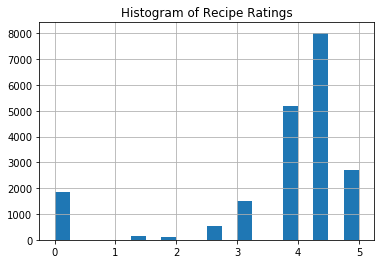

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [7]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

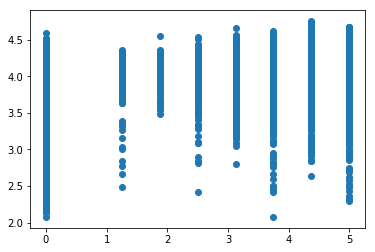

In [8]:
plt.scatter(Y, svr.predict(X))

In [9]:
svr.score(X, Y)

0.038565706512989184

## Challenge
Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

In [4]:
# we'll try to predict a good rating, defined as greater than 4.
raw_data['rating_binary'] = np.where(raw_data['rating']>4,1,0)

raw_data.rating_binary.value_counts(normalize=True)

# we have 53.6% good ratings and 46.4% not good

1    0.535508
0    0.464492
Name: rating_binary, dtype: float64

In [60]:
# get 30 mos correlated features.
corr = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).corr()['rating_binary']

fcols = list(corr.sort_values(ascending=False).iloc[1:31].index)

fcols

['rating_binary_bad',
 'bon appétit',
 'roast',
 'thanksgiving',
 'peanut free',
 'soy free',
 'dinner',
 'christmas',
 'grill/barbecue',
 'tree nut free',
 'backyard bbq',
 'fall',
 'grill',
 'stuffing/dressing',
 'goat cheese',
 "father's day",
 'dessert',
 'meat',
 'fourth of july',
 'low carb',
 'turkey',
 'pork tenderloin',
 'cranberry',
 'sausage',
 'cake',
 'brisket',
 'bake',
 'red wine',
 'lamb',
 'high fiber']

In [14]:
X = raw_data[fcols]
y = raw_data.rating_binary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=3)

In [15]:
svc = SVC()

svc.fit(X_train,y_train)
print(svc.score(X_train,y_train))


bcm = mdst.Binary_confusion_matrix(y_test,svc.predict(X_test))
bcm.display_metrics()
bcm.df_pct # binary confusion matrix df where each cell value shows pct of total

0.578802992519
Accuracy = 0.5681959855379628
Sensitivity = 0.6583002568293252
Specificity = 0.4649545211342964
Precision = 0.5850191928623301
negative predictive value = 0.5428705294393253



,pred_true,pred_false
actual_true,35.15,18.25
actual_false,24.93,21.67


In [33]:
svc = SVC(C=1.0, kernel='sigmoid')

svc.fit(X_train,y_train)
print(svc.score(X_train,y_train))


bcm = mdst.Binary_confusion_matrix(y_test,svc.predict(X_test))
bcm.display_metrics()
bcm.df_pct # binary confusion matrix df where each cell value shows pct of total

0.576558603491
Accuracy = 0.5731828949008851
Sensitivity = 0.725309362596311
Specificity = 0.398876404494382
Precision = 0.5802745867189689
negative predictive value = 0.558950328022493



,pred_true,pred_false
actual_true,38.73,14.67
actual_false,28.01,18.59


In [44]:
svc = SVC(C=5, gamma=.1)

svc.fit(X_train,y_train)
print(svc.score(X_train,y_train))


bcm = mdst.Binary_confusion_matrix(y_test,svc.predict(X_test))
bcm.display_metrics()
bcm.df_pct # binary confusion matrix df where each cell value shows pct of total

0.604488778055
Accuracy = 0.5730582221668121
Sensitivity = 0.571445248657483
Specificity = 0.5749063670411985
Precision = 0.6063421280812585
negative predictive value = 0.5393399422763208



,pred_true,pred_false
actual_true,30.51,22.88
actual_false,19.81,26.79


In [38]:
svc = SVC(gamma=.1)

svc.fit(X_train,y_train)
print(svc.score(X_train,y_train))


bcm = mdst.Binary_confusion_matrix(y_test,svc.predict(X_test))
bcm.display_metrics()
bcm.df_pct # binary confusion matrix df where each cell value shows pct of total

0.584039900249
Accuracy = 0.5729958857997756
Sensitivity = 0.6962409526033154
Specificity = 0.4317817014446228
Precision = 0.5840188014101058
negative predictive value = 0.5536878216123499



,pred_true,pred_false
actual_true,37.18,16.22
actual_false,26.48,20.12


In [45]:
# now lets try to predict a bad rating, defined as less than 2.
raw_data['rating_binary_bad'] = np.where(raw_data['rating']>=2,1,0)

raw_data.rating_binary_bad.value_counts(normalize=True)

# we have 89.4% not bad ratings and 10.6% bad ratings

1    0.894075
0    0.105925
Name: rating_binary_bad, dtype: float64

In [48]:
# get 30 mos correlated features.
corr = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'rating_binary'], 1).corr().iloc[:,-1]

fcols = list(corr.sort_values(ascending=False).iloc[1:31].index)

fcols

['bon appétit',
 'sauté',
 'bake',
 'peanut free',
 'soy free',
 'gourmet',
 'tree nut free',
 'quick & easy',
 'fall',
 'winter',
 'onion',
 'no sugar added',
 'kosher',
 'roast',
 'vegetable',
 'pasta',
 'tomato',
 'pescatarian',
 'cheese',
 'herb',
 'high fiber',
 'side',
 'sugar conscious',
 'potato',
 'vegetarian',
 'beef',
 'pork',
 'dinner',
 'chicken',
 'low cal']

In [49]:
X = raw_data[fcols]
y = raw_data.rating_binary_bad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=3)

In [50]:
svc = SVC()

svc.fit(X_train,y_train)
print(svc.score(X_train,y_train))


bcm = mdst.Binary_confusion_matrix(y_test,svc.predict(X_test))
bcm.display_metrics()
bcm.df_pct # binary confusion matrix df where each cell value shows pct of total

0.895511221945
Accuracy = 0.8937164942027178
Sensitivity = 1.0
Specificity = 0.0
Precision = 0.8937164942027178
negative predictive value = nan



c:\python36-32\mdst.py:23: RuntimeWarning: invalid value encountered in longlong_scalars
  self.neg_pred_val = self.tn/(self.tn+self.fn)


,pred_true,pred_false
actual_true,89.37,0.0
actual_false,10.63,0.0


In [59]:
svc = SVC(gamma=2)

svc.fit(X_train,y_train)
print(svc.score(X_train,y_train))


bcm = mdst.Binary_confusion_matrix(y_test,svc.predict(X_test))
bcm.display_metrics()
bcm.df_pct # binary confusion matrix df where each cell value shows pct of total

0.921695760599
Accuracy = 0.890786684952001
Sensitivity = 0.9938620352932971
Specificity = 0.02404692082111437
Precision = 0.8954314082825363
negative predictive value = 0.3178294573643411



,pred_true,pred_false
actual_true,88.82,0.55
actual_false,10.37,0.26


In [57]:
svc = SVC(gamma=10)

svc.fit(X_train,y_train)
print(svc.score(X_train,y_train))


bcm = mdst.Binary_confusion_matrix(y_test,svc.predict(X_test))
bcm.display_metrics()
bcm.df_pct # binary confusion matrix df where each cell value shows pct of total

0.927930174564
Accuracy = 0.8873581847649918
Sensitivity = 0.9887703145706912
Specificity = 0.03460410557184751
Precision = 0.8959676399949438
negative predictive value = 0.2681818181818182



,pred_true,pred_false
actual_true,88.37,1.00
actual_false,10.26,0.37
